In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
class Black_Scholes_model():
    def __init__(self, S0 = 100, K = 100, r = 0.05, sigma = 0.2, T = 0.01):
        self.S0 = S0 
        self.K = K
        self.r = r 
        self.sigma = sigma
        self.T = T
    def European_call(self):
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    def European_put(self):
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    @property
    def d1(self):
        return (np.log(self.S0/self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
    @property
    def d2(self):
        return self.d1  - self.sigma * np.sqrt(self.T)
    @property
    def delta_call(self):
        return norm.cdf(self.d1)
    @property
    def delta_put(self):
        return norm.cdf(self.d1) - 1
    @property
    def gamma(self):
        return norm.pdf(self.d1) / (self.S0 * self.sigma * np.sqrt(self.T))
    @property
    def vega(self):
        return self.S0 * norm.pdf(self.d1) * np.sqrt(self.T)
    @property 
    def theta_call(self):
        return -self.S0 * norm.pdf(self.d1) * self.sigma / (2 * np.sqrt(self.T)) - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    @property 
    def theta_put(self):
        return -self.S0 * norm.pdf(self.d1) * self.sigma / (2 * np.sqrt(self.T)) + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    @property
    def rho_call(self):
        return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    @property
    def rho_put(self):
        return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    def BS_call_market_price(self, market_price, tol = 1e-06, max_iter = 100):
        for _ in range(max_iter):
            BS_price = self.European_call()
            diff = market_price - BS_price
            if abs(diff) <= tol:
                break
            if self.vega < 0:
                self.sigma = None
                break
            self.sigma -= diff / self.vega
    def risk_neutral_implied_density(self):
        exponent = - (np.log(self.K / self.S0) - (self.r - 0.5 * self.sigma**2) * self.T) ** 2 / (2 * self.sigma ** 2 * self.T)
        return 1/(self.K*self.sigma*np.sqrt(2 * math.pi * self.T)) * np.exp(exponent)
    def greeks(self, K_array, T_array, type="Call"):
        if type == "Call":
            fig, axes = plt.subplots(3, 2, figsize = (14,6))
            for time in T_array:
                delta_call_array = []
                gamma_array =  []
                vega_array = []
                theta_array = []
                rho_array = []
                implied_density_array = []
                for strike in K_array:
                    delta_call_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).delta_call)
                    gamma_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).gamma)
                    vega_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).vega)
                    theta_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).theta_call)
                    rho_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).rho_call)
                    implied_density_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).risk_neutral_implied_density())
                axes[0][0].plot(K_array, delta_call_array, label = f"Time_to_expiry:{time:.3f}")
                axes[0][1].plot(K_array, gamma_array, label = f"Time_to_expiry:{time:.3f}")
                axes[1][0].plot(K_array, vega_array, label = f"Time_to_expiry:{time:.3f}")
                axes[1][1].plot(K_array, theta_array, label = f"Time_to_expiry:{time:.3f}")
                axes[2][0].plot(K_array, rho_array, label = f"Time_to_expiry:{time:.3f}")
                axes[2][1].plot(K_array, implied_density_array, label = f"Time_to_expiry:{time:.3f}")
            axes[0][0].legend()
            axes[0][0].set_xlabel("Strike")
            axes[0][0].set_ylabel("Delta")
            axes[0][1].legend()
            axes[0][1].set_xlabel("Strike")
            axes[0][1].set_ylabel("Gamma")
            axes[1][0].legend()
            axes[1][0].set_xlabel("Strike")
            axes[1][0].set_ylabel("Vega")
            axes[1][1].legend()
            axes[1][1].set_xlabel("Strike")
            axes[1][1].set_ylabel("Theta")
            axes[2][0].legend()
            axes[2][0].set_xlabel("Strike")
            axes[2][0].set_ylabel("Rho")
            axes[2][1].legend()
            axes[2][1].set_xlabel("Strike")
            axes[2][1].set_ylabel("Risk-Neutral Density")
            fig.tight_layout()
        if type == "Put":
            fig, axes = plt.subplots(3, 2, figsize = (14,6))
            for time in T_array:
                delta_call_array = []
                gamma_array =  []
                vega_array = []
                theta_array = []
                rho_array = []
                for strike in K_array:
                    delta_call_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).delta_put)
                    gamma_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).gamma)
                    vega_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).vega)
                    theta_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).theta_put)
                    rho_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).rho_put)
                    implied_density_array.append(Black_Scholes_model(S0=self.S0, K=strike, r=self.r, sigma=self.sigma, T=time).risk_neutral_implied_density())
                axes[0][0].plot(K_array, delta_call_array, label = f"Time_to_expiry:{time:.3f}")
                axes[0][1].plot(K_array, gamma_array, label = f"Time_to_expiry:{time:.3f}")
                axes[1][0].plot(K_array, vega_array, label = f"Time_to_expiry:{time:.3f}")
                axes[1][1].plot(K_array, theta_array, label = f"Time_to_expiry:{time:.3f}")
                axes[2][0].plot(K_array, rho_array, label = f"Time_to_expiry:{time:.3f}")
                axes[2][1].plot(K_array, implied_density_array, label = f"Time_to_expiry:{time:.3f}")
            axes[0][0].legend()
            axes[0][0].set_xlabel("Strike")
            axes[0][0].set_ylabel("Delta")
            axes[0][1].legend()
            axes[0][1].set_xlabel("Strike")
            axes[0][1].set_ylabel("Gamma")
            axes[1][0].legend()
            axes[1][0].set_xlabel("Strike")
            axes[1][0].set_ylabel("Vega")
            axes[1][1].legend()
            axes[1][1].set_xlabel("Strike")
            axes[1][1].set_ylabel("Theta")
            axes[2][0].legend()
            axes[2][0].set_xlabel("Strike")
            axes[2][0].set_ylabel("Rho")
            axes[2][1].legend()
            axes[2][1].set_xlabel("Strike")
            axes[2][1].set_ylabel("Risk-Neutral Density")
            fig.tight_layout()


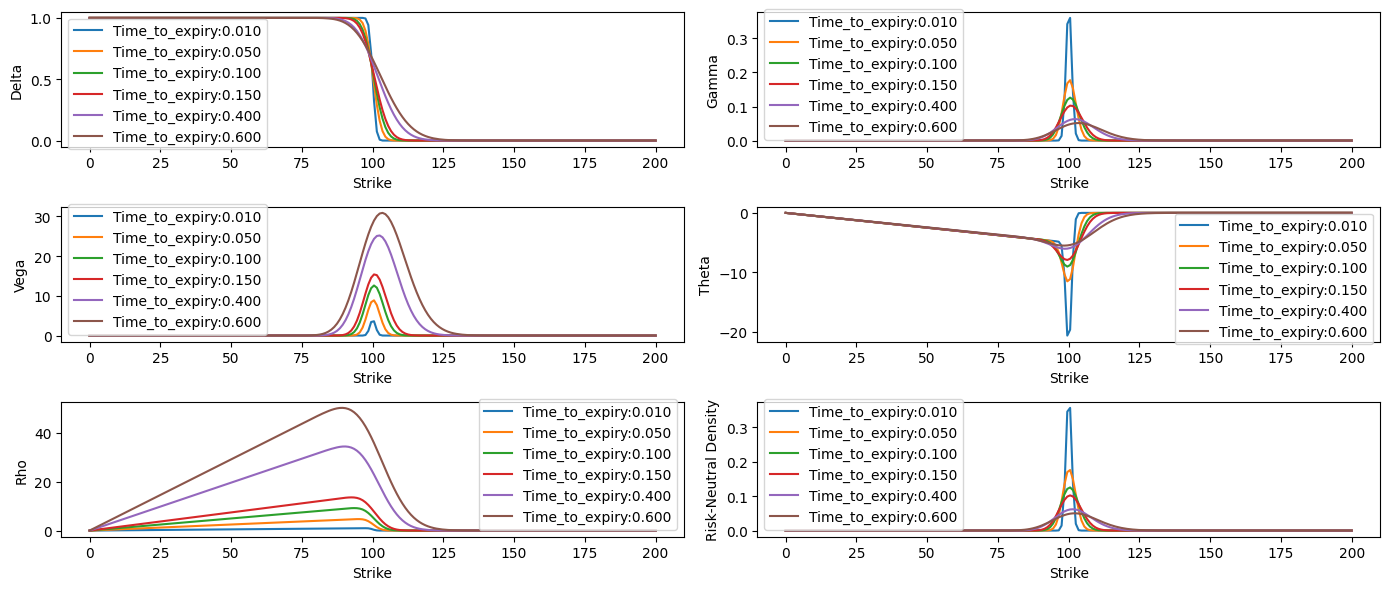

In [4]:
K_arr = np.linspace(0.01,200,200)
T_arr = [0.01, 0.05, 0.1, 0.15, 0.4, 0.6]

bl_model = Black_Scholes_model(sigma = 0.1)
bl_model.greeks(K_arr, T_arr, type = "Call")


In [8]:
bl = Black_Scholes_model(100, 100, 0.05, 0.01, 1.0)
bl.European_call()

np.float64(4.877057602069669)